In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import cirq as cirq
import numpy as np
import matplotlib.pyplot as plt
from xmps.iMPS import iMPS
import unitary_iMPS as qMPS

# qmps
This notebook walks through how we represent, optimise, and time evolve uniform matrix product states on a NISQ quantum computer. It depends on xmps, a matrix product state library available at https://github.com/fergusbarratt/xmps, and Cirq, google's quantum programming language available on PyPI.

# Intro to uniform Matrix Product States

An uniform matrix product state in right canonical form can be represented by a single repeated tensor

In [2]:
"""
...--A--A--A--A--A--A--...
  |  |  |  |  |  |
""";

Since we can put the above into left canonical form by a gauge transformation, the expectation value of any local observable can be expressed as follows

In [3]:
"""
         --A--...--A--
        |  |       |  |
<O>   = |  ----O----  r
        |  |       |  |
         --A--...--A--

""";

Where r is the largest right eigenvector of the transfer matrix

In [4]:
"""
--A--    ---
  |  |      |
  |  r =    r
  |  |      |
--A--    ---

""";

## Representation

In order to represent a uniform matrix product state of some bond dimension, two objects are sufficient

 - The state tensor A
 - The right eigenmatrix r
 
The main idea of this paper is that these can be represented or determined efficiently on a quantum computer, and the resulting quantum state, representing the state of a infinite, TI quantum system, can be optimized and manipulated in an efficient manner.

In [120]:
# A is a fixed state tensor, r is its right environment
A = iMPS().load('./fixtures/A.npy').left_canonicalise()
A, r = A[0], A.L 

# Get U and V for A and R
U = qMPS.StateTensor2(qMPS.left_orthogonal_tensor_to_unitary(A))
V = qMPS.Environment2(qMPS.environment_to_unitary(r))

### State Tensor

The A tensor of a matrix product state of bond dimension D can be represented on $\log_2(D)+1$ qubits as follows

In [5]:
"""       
            |0>|0>...|0>|0>
               \    j     /
i--A--j  =   |  |   ...  |
   |         -------------
   σ               U
             -------------
             |   ...  |  | 
            /    i     \/σ\
              \log_2(D)  +1
""";

Where we assume that the state unitary $U$ can be efficiently represented on a quantum computer. In the following we denote the required depth of $U$ as $p(D)$, where $p$ is subpolynomial, and generally we assume constant depth.

In code this is represented by the
`
StateTensor
`
class.

### How to get the environment for a given state tensor

#### Environment

The environment tensor is embedded in a unitary $V$ as follows

In [10]:
"""
            |0>|0>...|0>|0>
i--C--j  =   |  | ... |  |
             -------------
                   v
             -------------
             |  | ... |  | 
            /  i   \/  j  \
           \log_2(D)\log_2(D)
        

r = C@C.conj().T
""";

Where we assume that the environment unitary $V$ can be efficiently represented on a quantum computer. In the following we denote the depth of V as $q(D)$, where $q$ is subpolynomial, and generally we assume constant depth.

In code this is represented by the
`
Environment
`
class.

#### Algorithm

Given a StateTensor $U$ (corresponding to $A$), can we efficiently determine the Environment $V$ (corresponding to $r$) on the circuit?

The condition that $VV^\dagger$ is the right environment of U is that $\rho = \sigma$ on the following circuit.

In [9]:
""" 0 0 0 0 0 0 
    | | | | | | 
    | --- | | |       
    |  v  | | |  
    | --- | | |  
    | | | | | |  
    --- | --- |  
     u  |  v  |  
    --- | --- |  
    | | | | | |             
    ρ | | σ | |  

""";

### Tomography

As a first approximation, one can perform state tomography on the $\rho$ and $\sigma$ qubits. This method requires $\sim \mathcal{O}(p(D)3^{\log_2(D)})\sim \mathcal{O}(p(D)D^3)$ operations, but only $3\log_2(D)+1$ qubits. $\mathcal{O}(D^3)$ is the scaling of classical matrix multiplication and the dominant scaling of classical DMRG. Can we do better?

In code, the above objective function is available both with full calculation of the wavefunction and via sampling as follows

In [132]:
print(qMPS.full_tomography_env_objective_function(U, V),
      qMPS.sampled_tomography_env_objective_function(U, V, reps=10000))

2.7391019230549318e-08 0.020923670806051245


### Power Method

Instead of representing the environment compactly, one can represent it as the contraction of $K$ StateTensors, i.e. since it is the largest eigenvector of a matrix, one can use the power method. This is equivalent to approximating the state of the infinite chain by the state of a length $K+1$ uniform chain.

In [ ]:
"""
            |0>|0>...|0>|0>        0 0 0 ... 0     0 0 
i--r--j  =   |  | ... |  |     =   | | | ... |     | |
             -------------         | | | ... ---------
                   v               | | | ...     U     
             -------------         | | | ... --------- 
             |  | ... |  |         | | | ... | ... | | 
            /      \/     \        | | | .........   K
           \log_2(D)\log_2(D)      | | | .........
                                   | | | ... |
                                   | ---------
                                   |     U            
                                   | ---------         
                                   | | ... | | 
                                   | | ... | 2
                                   ---------
                                       U            
                                   ---------           
                                   | ... | | 
                                           1


""";

 - The power method has an error scaling $\epsilon \sim |\frac{\lambda_1}{\lambda_2}|^K$. where $\lambda_i$ is the $i$th largest eigenvalue of the matrix.
 - This method requires $\mathcal{O}(\log_2(D/\epsilon))$ qubits, and requires $p(D)\log(1/\epsilon)$ operations.
 - We can do better than polynomial in $D$! Can we improve the qubit and depth scaling?

### Swap Test

The swap test estimates the overlap $\mathrm{tr}(\rho \sigma)$ between the two states $\rho$ and $\sigma$. Naive implementations require deep circuits, but it can be done in constant depth. 

#### Horizontal 

The Swap Test Circuits use the circuits introduced in [1]. These circuits have a lower depth and lower $T$ gate count than circuits using the usual SWAP gates. Below is an example swap circuit a for bond dimension 2 MPS: 

<img src="circuits/horizontal_swap_test.png" ,width = 200>

This required $4\log_2(D)+1$ qubits but a constant additional depth of just 2 gates. The state overlap is maximised when the number of times that $ \left|11\right\rangle $ is measured is minimized. For multiple qubit measurements the CNOT and H gates can be done in parallel ensuring a constant gate depth. 

<small>[1] [*The SWAP test and the Hong-Ou-Mandel effect are equivalent*](https://arxiv.org/pdf/1303.6814.pdf), Juan Carlos Garcia-Escartin and Pedro Chamorro-Posada, 2013</small>


In [30]:
# generate a random unitary to start
from scipy.stats import unitary_group
from qmps.represent import HorizontalSwapOptimizer as HSO, HorizontalSampleSwapOptimizer as SampleHSO, Tensor 
U = Tensor(unitary_group.rvs(4), 'U')

optimizer = HSO(U, qaoa_depth = 20)
optimizer.settings({'store_values':True,
                    'maxiter':500,
                    'tol':1e-8,
                    'method':'Powell',
                    'verbose':True})
optimizer.get_env()

0:0.1532444804906845
1:0.1532444804906845
Optimization terminated successfully.
         Current function value: 0.153244
         Iterations: 2
         Function evaluations: 3000
Reason for termination is Optimization terminated successfully.


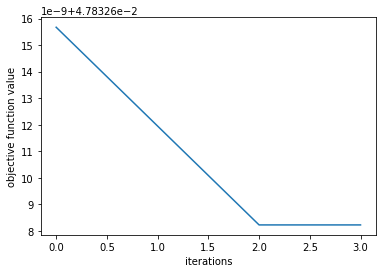

In [27]:
optimizer.plot_convergence()

In [ ]:
cirq.optimizer.v

#### Vertical

The vertical swap test uses $2\log_2(D)+1$ qubits with an increased circuit depth:

<img src="circuits/vertical_swap_test.png" ,width = 250>

The state overap is maximized when the probability of measuring the all zero state, $\left|0...\right\rangle$, on the auxillary qubits of the unitary $U$ is maximized.

### State

All q-local observables of the infinite TI system can be obtained by measurements of corresponding pauli string on the following combination of $U$ and $V$ on the qubits marked $1 \ldots N$

In [6]:
"""
         --A--...--A--
        |  |       |  |
<O>   = |  ----O----  r
        |  |       |  |
         --A--...--A--

      =
        |0>......................|0>
         | | | ... | | ... || ... |
         | | | ... | ---------------
         | | | ... |        V         
         | | | ... | ---------------           
         | | | ... | | ... || ... |
         | | | ... | | ... |
         | | | ... ---------
         | | | ...     U            
         | | | ... ---------            
         | | | ... | ... | | 
         | | | .........   N
         | | | .........
         | | | ... |
         | ---------
         |     U            
         | ---------            
         | | ... | | 
         | | ... | 2
         ---------
             U            
         ---------            
         | ... | | 
                 1
            
""";

and require the creation of a circuit on $(N+1)\log_2(D)$ qubits.

In code the `State` class is the combination of a `StateTensor` and `Environment` object, and takes as an argument $N$.

## Optimization

Classically the state of the art for finding ground states of 1D spin chains is the DMRG algorithm. DMRG is a variational update over matrix product states. Here we outline how to perform the same task on the quantum computer.

## Time Evolution

Time Dependant Variational Principle [2] is utilized to time evolve the representation of the infinite MPS. The MPS evolves under an $n$-qubit Hamiltonian by applying the $n$-qubit Unitary to the $n$ physical qubits on the `State` class. In general this evolution will make the state leave the manifold of MPS states. This state is then projected onto a state on the manifold that maximises the overlap with the evolved state.

The circuit used to find this projection is:

<img src="circuits/time_evolution.png" ,width = 300>

Overlap of the two states is maximised when the porbability of measuring the all 0 state is maximized.

Here the unitary $U^{\prime}$ is varied while keeping $V$ constant to maximize the overlap between the original MPS that has evolved for a time $t$ under a single qubit Hamiltonian, and the candidate MPS state. Once the optimal $U$ is found the Representation code, outlined above, is used to determine $V^{\prime}$ to ensure this remains a valid translationally-invariant MPS.

<small>[2] [*Time-dependent variational principle for quantum lattices
*](https://arxiv.org/pdf/1103.0936.pdf), Jutho Haegeman et al, 2011
</small>


Once a state tensor $U$ and time evolution unitary $U_{H} = e^{iH\delta t}$ is specified the `MPSTimeEvolve` class can be used to evolve the MPS for a time $\delta t$ using the method `MPSTimeEvolve.evolve_single_step()`.
The attributes `MPSTimeEvolve.u` & `MPSTimeEvolve.v` are the unitaries that specify the state and environment of the evolved states. 